In [5]:
import torch
from torch import nn
from torch.autograd import grad
import numpy as np
import time
import matplotlib.pyplot as plt

In this notebook we will be testing various key components to our neural network to make sure that everything works well

## Testing Derivatives

In [2]:
def derivativespsi(X, T, psi):
    psi_real, psi_imag = psi.real, psi.imag  # Extract real & imaginary parts

    dpsi_dx_real, = torch.autograd.grad(psi_real, X, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dx_imag, = torch.autograd.grad(psi_imag, X, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dx = dpsi_dx_real + 1j * dpsi_dx_imag  # Reconstruct complex derivative

    dpsi_dx2_real, = torch.autograd.grad(dpsi_dx.real, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_real), 
                                         create_graph=True)
    dpsi_dx2_imag, = torch.autograd.grad(dpsi_dx.imag, X, 
                                         grad_outputs=torch.ones_like(dpsi_dx_imag), 
                                         create_graph=True)
    dpsi_dx2 = dpsi_dx2_real + 1j * dpsi_dx2_imag  # Reconstruct complex second derivative

    dpsi_dt_real, = torch.autograd.grad(psi_real, T, 
                                        grad_outputs=torch.ones_like(psi_real), 
                                        create_graph=True)
    dpsi_dt_imag, = torch.autograd.grad(psi_imag, T, 
                                        grad_outputs=torch.ones_like(psi_imag), 
                                        create_graph=True)
    dpsi_dt = dpsi_dt_real + 1j * dpsi_dt_imag  # Reconstruct complex time derivative

    return dpsi_dt, dpsi_dx2

### Verification with a Gaussian

The wave function we will use is a Gaussian in the $x$-plane:

$$
\psi(x,t) = A \exp\left(-\frac{x^2}{2\sigma^2} + i \omega t\right)
$$

Where:
- $ A $ is the normalization.
- $ \sigma $ is the width of the Gaussian.
- $ \omega $ is the angular frequency.

#### Expected Derivatives

1. **Derivative with respect to time**:

$$
\frac{\partial \psi}{\partial t} = i \omega \psi(x,t)
$$

2. **First derivative with respect to $x$**:

$$
\frac{\partial \psi}{\partial x} = -\frac{x}{\sigma^2} \psi(x,t)
$$

3. **Second derivative with respect to $x$**:

$$
\frac{\partial^2 \psi}{\partial x^2} = \left( -\frac{1}{\sigma^2} + \frac{x^2}{\sigma^4} \right) \psi(x,t)
$$



In [4]:
# Define the X and T mesh
Nx, Nt = 100, 100
x_train = torch.linspace(-8, 8, Nx, requires_grad=True)
t_train = torch.linspace(0, 100, Nt, requires_grad=True)

# Define the Gaussian function
sigma = 3.0
omega = 1.5
A = 2.0

# The Gaussian wave function
ln_abs_psi = -x_train**2 / (2 * sigma**2)
phase = omega * t_train
psi = torch.exp(ln_abs_psi + 1j * phase)

# Calculate the derivatives using the derivatives function
dpsi_dt, dpsi_dx2= derivativespsi(x_train, t_train, psi)

# Expected derivatives (analytical)
expected_dpsi_dt = 1j * omega * torch.exp(ln_abs_psi) * torch.exp(1j * phase)
expected_dpsi_dx2 = (-(1 / sigma**2) + (x_train**2 / sigma**4)) * torch.exp(ln_abs_psi) * torch.exp(1j * phase)


# Calculate the maximum error
error_dpsi_dt = torch.max(torch.abs(dpsi_dt - expected_dpsi_dt))
error_dpsi_dx2 = torch.max(torch.abs(dpsi_dx2 - expected_dpsi_dx2))


print(f"Maximum error for the time derivative: {error_dpsi_dt.item()}")
print(f"Maximum error for the second derivative with respect to x: {error_dpsi_dx2.item()}")

Maximum error for the time derivative: 1.3328003944934608e-07
Maximum error for the second derivative with respect to x: 1.1330028470979414e-08


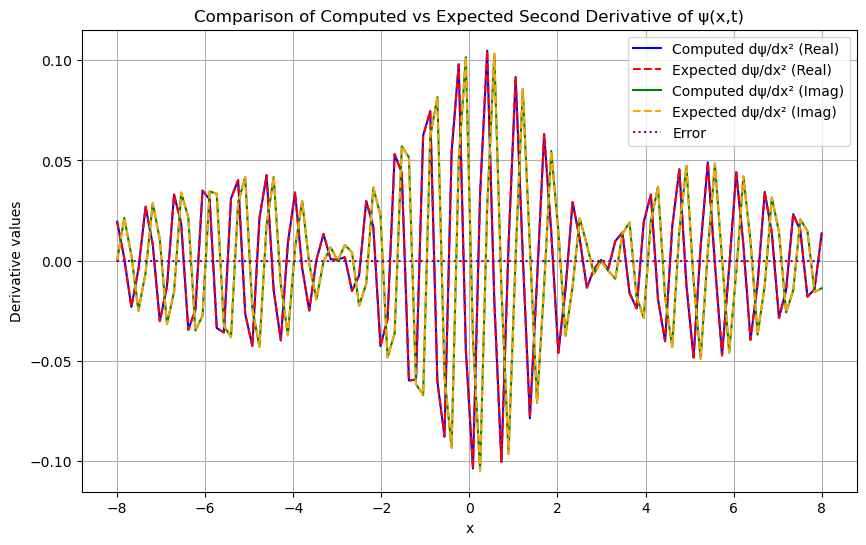

In [6]:

# Visualize the error

# Plot the computed vs expected second derivatives
plt.figure(figsize=(10, 6))
plt.plot(x_train.detach().numpy(), dpsi_dx2.detach().numpy().real, label="Computed dψ/dx² (Real)", color="blue")
plt.plot(x_train.detach().numpy(), expected_dpsi_dx2.detach().numpy().real, label="Expected dψ/dx² (Real)", color="red", linestyle='--')
plt.plot(x_train.detach().numpy(), dpsi_dx2.detach().numpy().imag, label="Computed dψ/dx² (Imag)", color="green")
plt.plot(x_train.detach().numpy(), expected_dpsi_dx2.detach().numpy().imag, label="Expected dψ/dx² (Imag)", color="orange", linestyle='--')

# Plot the absolute error
error = torch.abs(dpsi_dx2 - expected_dpsi_dx2)
plt.plot(x_train.detach().numpy(), error.detach().numpy(), label="Error", color="purple", linestyle=':')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Derivative values')
plt.title('Comparison of Computed vs Expected Second Derivative of ψ(x,t)')
plt.legend()
plt.grid(True)
plt.show()

### Testing PyTorch Derivatives with Gaussian Neural Network

In this section, we are testing if the derivatives computed using PyTorch are correct. We create a simple neural network that approximates the Gaussian function, then compute its derivatives with respect to the input. These computed derivatives are compared to the analytical values of the Gaussian function's derivatives.

To do a meshgrid for $x$ and $t$ is created with specified ranges and divisions. The resulting grid is reshaped into the required format `[batch_size, feature_size]` for the neural network, where the batch size is $Nx \times Nt$ (total grid points) and the feature size is 2 (representing $x$ and $t$). This ensures the neural network receives the correctly sized input for both coordinates and their derivatives.



In [7]:
# Hardware (CPU or GPU)
dev = 'cpu' # can be changed to 'cuda' for GPU usage
device = torch.device(dev)
# Mesh parameters
# For x
Nx = 100                    # Mesh division
train_ax = -8                      # Mesh lower limit
train_bx = 8                        # Mesh upper limit
x_train = torch.linspace(train_ax, train_bx, Nx, requires_grad=True, device=device, dtype=torch.float64) 

#For t
Nt = 100                    # Mesh division
train_at = 0                      # Mesh lower limit
train_bt = 100                     # Mesh upper limit

t_train = torch.linspace(train_at, train_bt, Nt, requires_grad=True, device=device, dtype=torch.float64)

# Create 2D mesh grids
XT_train = torch.meshgrid(x_train, t_train, indexing="ij")  # Shape (Nx, Nt)

X = XT_train[0].reshape(-1, 1).to(device) # Shape (Nx * Nt, 1)
T = XT_train[1].reshape(-1, 1).to(device) # Shape (Nx * Nt, 1)

X = X.requires_grad_(True).to(device)  # Enable gradient tracking for X
T = T.requires_grad_(True).to(device)  # Enable gradient tracking for T

XT_train = torch.stack([X, T], dim=-1).reshape(-1, 2) # Shape (Nx * Nt, 2)

In [8]:
class GaussianNN(nn.Module):
    """
    A neural network that models a Gaussian wave function.
    
    Inputs:
    - x (torch.Tensor): Spatial coordinate.
    - t (torch.Tensor): Time coordinate.
    
    Outputs:
    - ln_abs_psi (torch.Tensor): Natural logarithm of the absolute value of the wave function.
    - phase (torch.Tensor): Phase component of the wave function.
    - sigma (torch.nn.Parameter): Trainable Gaussian width parameter.
    - omega (torch.nn.Parameter): Trainable angular frequency parameter.
    """
    def __init__(self):
        super(GaussianNN, self).__init__()
        
        # Trainable parameter representing the width of the Gaussian function
        self.sigma = nn.Parameter(torch.tensor(1.0))
        
        # Trainable parameter representing the angular frequency
        self.omega = nn.Parameter(torch.tensor(0.0))

    def forward(self, x, t):
        # Compute the logarithm of the absolute value of the wave function
        ln_abs_psi = -x**2 / (2 * self.sigma.pow(2))
        
        # Compute the phase component of the wave function
        phase = self.omega * t
        
        return ln_abs_psi, phase

In [9]:
# Compute ln_abs_psi and phase for the entire mesh grid (X, T)
net = GaussianNN().to(device)
sigma=net.sigma.item()
omega=net.omega.item()
ln_abs_psi, phase = net(X, T)

In [10]:

A = 1.0
# Calculate the derivatives using the derivatives function
psi = torch.exp(ln_abs_psi + 1j * phase)
dpsi_dt, dpsi_dx2= derivativespsi(X, T, psi)

# Expected derivatives (analytical)
expected_dpsi_dt = 1j * omega * torch.exp(ln_abs_psi) * torch.exp(1j * phase)
#expected_dln_abs_psi_dx = (-X/sigma**2)
expected_dpsi_dx2 = torch.exp(ln_abs_psi) * torch.exp(1j * phase)*(-(1 / sigma**2) + (X.pow(2) / sigma**4))

# Calculate the sum of the error
error_dpsi_dt = torch.abs(dpsi_dt - expected_dpsi_dt)
total_error_dpsi_dt=torch.sum(error_dpsi_dt)
#error_dln_abs_psi_dx = torch.abs(dln_abs_psi_dx-expected_dln_abs_psi_dx)
#total_error_dln_abs_psi_dx=torch.sum(error_dln_abs_psi_dx)
error_dpsi_dx2 = torch.abs(dpsi_dx2 - expected_dpsi_dx2)
total_error_dpsi_dx2=torch.sum(error_dpsi_dx2)
print(f"Total error for the time derivative: {total_error_dpsi_dt.item()}")
#print(f"Total error for the first derivative with respect to x: {total_error_dln_abs_psi_dx.item()}")
print(f"Total error for the second derivative with respect to x: {total_error_dpsi_dx2.item()}")
print(f"Max error for the second derivative with respect to x: {torch.max(error_dpsi_dx2).item()}")

Total error for the time derivative: 0.0
Total error for the second derivative with respect to x: 1.631201878694132e-13
Max error for the second derivative with respect to x: 1.1102230246251565e-16


/Users/Eli/anaconda3/lib/python3.11/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


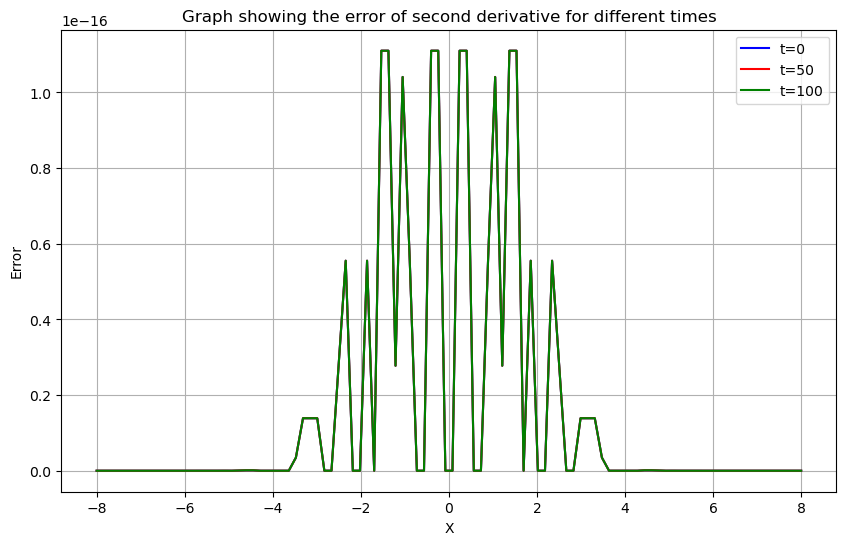

In [11]:

# Visualize the error

# Plot the errors of the second derivatives
plt.figure(figsize=(10, 6))
X=X.resize(Nx,Nt)
error_dpsi_dx2=error_dpsi_dx2.resize(Nx,Nt)

plt.plot(X[:,0].detach().numpy(), error_dpsi_dx2[:,0].detach().numpy(), label="t=0", color="blue")
plt.plot(X[:,50].detach().numpy(), error_dpsi_dx2[:,50].detach().numpy(), label="t=50", color="red")
plt.plot(X[:,99].detach().numpy(), error_dpsi_dx2[:,99].detach().numpy(), label="t=100", color="green")

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Error')
plt.title('Graph showing the error of second derivative for different times')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions

- For the time derivative, there is no significant error, even when varying omega.
- For the second derivative with respect to $ x $, we have errors but given the use of 32-bit floating point precision (`float32`), these errors are likely insignificant, as they fall within the typical error tolerance for this precision.


## Network
Our neural network is designed to solve the time-dependent Schrödinger equation (TDSE) for a one-dimensional quantum harmonic oscillator. The general form of the TDSE is:

$$
i \frac{\partial \psi}{\partial t} = \hat{H} \psi,
$$

where $ \hat{H} $ is the Hamiltonian operator. For the quantum harmonic oscillator, the Hamiltonian is given by:

$$
\hat{H} = -\frac{1}{2} \frac{\partial^2}{\partial x^2} + \frac{x^2}{2}.
$$

Thus, the Schrödinger equation for our system becomes:

$$
i \frac{\partial \psi}{\partial t} = \left( -\frac{1}{2} \frac{\partial^2}{\partial x^2} + \frac{x^2}{2} \right) \psi.
$$

To approximate the wavefunction $ \psi(x,t) $, we construct a neural network that takes as input the spatial coordinate $ x $ and time $ t $ and outputs two components: the logarithm of the absolute value of the wavefunction, $ \ln |\psi| $, and its phase. The wavefunction is then reconstructed as:

$$
\psi(x,t) = e^{\ln |\psi(x,t)|} e^{i \theta(x,t)}.
$$

The neural network consists of a single hidden layer with $ N_{\mathrm{hid}} $ neurons and follows the structure:

$$
f(x) = \sum^{N_{\mathrm{hid}}}_{i=1} W^{(2)}_i \sigma\left(W^{(1)}_i x + B_i\right),
$$

where $ W^{(1)} $ and $ W^{(2)} $ are the weight matrices, $ B $ is the bias vector, and $ \sigma $ is the activation function. The network parameters are initialized to specific ranges to ensure stable learning.

To train the network, we define a loss function based on the TDSE. First, we compute the necessary derivatives using automatic differentiation:

$$
\frac{\partial \psi}{\partial t}, \quad \frac{\partial^2 \psi}{\partial x^2}.
$$

Substituting these into the Schrödinger equation, we obtain the residual:

$$
\mathcal{R} = i \frac{\partial \psi}{\partial t} - \hat{H} \psi = i \frac{\partial \psi}{\partial t} + \frac{1}{2} \frac{\partial^2 \psi}{\partial x^2} - \frac{x^2}{2} \psi.
$$

The loss function is then defined as the squared norm of this residual over the training domain:

$$
\mathcal{L} = \sum_{x,t} \left| \mathcal{R} \right|^2.
$$

Minimizing $ \mathcal{L} $ ensures that the learned wavefunction satisfies the Schrödinger equation at each point in the discretized space-time domain.


In [12]:
# Hardware (CPU or GPU)
dev = 'cpu' # can be changed to 'cuda' for GPU usage
device = torch.device(dev)

# Network hyperparameters
Nin = 2   # Inputs to the neural network
Nout = 2  # Outputs of the neural network
Nhid = 4  # Nodes in the hidden layer

# Network parameters.
seed = 1                                       # Seed of the random number generator
torch.manual_seed(seed)
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients size 4x1 with value from -1 to0
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters size 4 with values from -2 to 0
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients size 1x4 with values from 0 to 1

# Training hyperparameters
epochs = 3000
lr = 2e-2  # Learning rate

# Mesh parameters
# For x
Nx = 100                    # Mesh division
train_ax = -8                      # Mesh lower limit
train_bx = 8                        # Mesh upper limit
x_train = torch.linspace(train_ax, train_bx, Nx, requires_grad=True, device=device) 

#For t
Nt = 100                    # Mesh division
train_at = 0                      # Mesh lower limit
train_bt = 100                     # Mesh upper limit

t_train = torch.linspace(train_at, train_bt, Nt, requires_grad=True, device=device)

# Create 2D mesh grids
XT_train = torch.meshgrid(x_train, t_train, indexing="ij")  # Shape (Nx, Nt)



X = XT_train[0].reshape(-1, 1).to(device)
T = XT_train[1].reshape(-1, 1).to(device)

X = X.requires_grad_(True).to(device)  # Enable gradient tracking for X
T = T.requires_grad_(True).to(device)  # Enable gradient tracking for T

XT_train = torch.stack([X, T], dim=-1).reshape(-1, 2) # Shape (Nx * Nt, 2)

In [13]:
class HarmonicNQS(nn.Module):
    def __init__(self, W1, B, W2):
        super(HarmonicNQS, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=True)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        # So we don't get random initialization
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

In [14]:
net = HarmonicNQS(W1, B, W2).to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNQS(
  (lc1): Linear(in_features=2, out_features=4, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=4, out_features=2, bias=True)
)


In [15]:
optimizer = torch.optim.RMSprop(params=net.parameters(), lr=lr)

In [16]:
def loss():
    ln_abs_psi = net(XT_train)[:,0].reshape(-1,1) # Shape (Nx*Nt,1)
    phase = net(XT_train)[:,1].reshape(-1,1) # Shape (Nx*Nt,1)
    psi=torch.exp(ln_abs_psi) * torch.exp(1j * phase) # Shape (Nx*Nt,1)
    
    # Compute derivatives
    dpsi_dt, dpsi_dx2 = derivativespsi(X, T, psi)
    
    # Compute hamiltonian and loss
    H=-dpsi_dx2/2 + (X**2)/2 * psi
    loss=torch.abs(1j * dpsi_dt - H)**2
    
    return loss.sum(), ln_abs_psi, phase

### Checking the hamiltonian

To verify that the implemented Hamiltonian is correct, we will test it using the ground-state wave function of the harmonic oscillator, which is a Gaussian function given by:

$$
\psi_0(x) = A e^{-x^2 / 2}
$$

So it's our gaussian network with $$\omega=0$$ i $$\sigma=1$$. In quantum mechanics, we know that when the Hamiltonian of the harmonic oscillator acts on this function, the expected result is:

$$
H \psi_0(x) = \frac{1}{2} \psi_0(x)
$$

Thus, if our numerical computation returns this result, we can confirm that the Hamiltonian has been correctly implemented.


In [17]:
# Hardware (CPU or GPU)
dev = 'cpu' # can be changed to 'cuda' for GPU usage
device = torch.device(dev)
# Mesh parameters
# For x
Nx = 100                    # Mesh division
train_ax = -8                      # Mesh lower limit
train_bx = 8                        # Mesh upper limit
x_train = torch.linspace(train_ax, train_bx, Nx, requires_grad=True, device=device, dtype=torch.float64) 

#For t
Nt = 100                    # Mesh division
train_at = 0                      # Mesh lower limit
train_bt = 100                     # Mesh upper limit

t_train = torch.linspace(train_at, train_bt, Nt, requires_grad=True, device=device, dtype=torch.float64)

# Create 2D mesh grids
XT_train = torch.meshgrid(x_train, t_train, indexing="ij")  # Shape (Nx, Nt)

X = XT_train[0].reshape(-1, 1).to(device) # Shape (Nx * Nt, 1)
T = XT_train[1].reshape(-1, 1).to(device) # Shape (Nx * Nt, 1)

X = X.requires_grad_(True).to(device)  # Enable gradient tracking for X
T = T.requires_grad_(True).to(device)  # Enable gradient tracking for T

XT_train = torch.stack([X, T], dim=-1).reshape(-1, 2) # Shape (Nx * Nt, 2)

In [18]:
class GaussianNN(nn.Module):
    """
    A neural network that models a Gaussian wave function.
    
    Inputs:
    - x (torch.Tensor): Spatial coordinate.
    - t (torch.Tensor): Time coordinate.
    
    Outputs:
    - ln_abs_psi (torch.Tensor): Natural logarithm of the absolute value of the wave function.
    - phase (torch.Tensor): Phase component of the wave function.
    """
    def __init__(self):
        super(GaussianNN, self).__init__()
        
        # Trainable parameter representing the width of the Gaussian function
        self.sigma = nn.Parameter(torch.tensor(1.0))
        
        # Trainable parameter representing the angular frequency
        self.omega = nn.Parameter(torch.tensor(0.0))

    def forward(self, x, t):
        # Compute the logarithm of the absolute value of the wave function
        ln_abs_psi = -x**2 / (2 * self.sigma.pow(2))
        
        # Compute the phase component of the wave function
        phase = self.omega * t
        
        return ln_abs_psi, phase

In [20]:
# Compute ln_abs_psi and phase for the entire mesh grid (X, T)
net = GaussianNN().to(device)
ln_abs_psi, phase = net(X, T)
psi=torch.exp(ln_abs_psi) * torch.exp(1j * phase)
dpsi_dt, dpsi_dx2= derivativespsi(X, T, psi)

# Check if our hamiltonian gives the predicted value
H=(-dpsi_dx2/2 + (X**2)/2 * psi).sum()
expected_H=(0.5*psi).sum()
print(f"Total error for H: {(H-expected_H).item()}")

Total error for H: 0j


### Checking the loss function
To verify the correctness of our loss function, we test it using a known non-stationary solution of the time-dependent Schrödinger equation. Specifically, we consider the time-evolving ground-state wavefunction of the harmonic oscillator, given by  

$$
\psi_0(x,t) = e^{-iE_0 t} e^{-x^2 / 2},
$$  

where $E_0 = \frac{1}{2}$ is the ground-state energy (our gaussian with $\sigma = 1$ and $\omega= \frac{-1}{2}$). Since it satisfies the Schrödinger equation exactly, our loss function should evaluate to zero when applied to this wavefunction.


In [21]:
class GaussianNN(nn.Module):
    """
    A neural network that models a Gaussian wave function.
    
    Inputs:
    - x (torch.Tensor): Spatial coordinate.
    - t (torch.Tensor): Time coordinate.
    
    Outputs:
    - ln_abs_psi (torch.Tensor): Natural logarithm of the absolute value of the wave function.
    - phase (torch.Tensor): Phase component of the wave function.
    """
    def __init__(self):
        super(GaussianNN, self).__init__()
        
        # Trainable parameter representing the width of the Gaussian function
        self.sigma = nn.Parameter(torch.tensor(1.0))
        
        # Trainable parameter representing the angular frequency
        self.omega = nn.Parameter(torch.tensor(-0.5))

    def forward(self, x, t):
        # Compute the logarithm of the absolute value of the wave function
        ln_abs_psi = -x**2 / (2 * self.sigma.pow(2))
        
        # Compute the phase component of the wave function
        phase = self.omega * t
        
        return ln_abs_psi, phase

In [22]:
# Compute ln_abs_psi and phase for the entire mesh grid (X, T)
net = GaussianNN().to(device)
ln_abs_psi, phase = net(X, T)
psi=torch.exp(ln_abs_psi) * torch.exp(1j * phase)
dpsi_dt, dpsi_dx2= derivativespsi(X, T, psi)

In [23]:
# Compute Hamiltonian and loss
H = -dpsi_dx2 / 2 + (X**2) / 2 * psi

# Compute the squared loss
loss=torch.abs(1j*dpsi_dt - H)**2


# Print structured message
print(f"The loss function is {loss.sum():.4e}, which can be considered zero since the maximum of the loss function is {loss.max():.4e}, which is below the precision of float64 of 10^-15.")

The loss function is 3.8531e-30, which can be considered zero since the maximum of the loss function is 1.3096e-32, which is below the precision of float64 of 10^-15.


### Testing the Ground State

We are also testing the loss function on the known ground state solution of the time-dependent Schrödinger equation for the harmonic oscillator. The wavefunction for the ground state is:

$$
\psi_0(x, t) = e^{-i \omega t} e^{-\frac{x^2}{2}},
$$

where $\omega$ is the frequency of the oscillator.

When we apply our Hamiltonian to the wavefunction, it gives:

$$
H \psi_0(x, t) = \frac{1}{2} \psi_0(x, t),
$$

since we are assuming $\omega = 1$ in the Hamiltonian.

The time derivative of the wavefunction is:

$$
\frac{\partial \psi_0}{\partial t} = -i \omega e^{-i \omega t} e^{-\frac{x^2}{2}} = -i \omega \psi_0(x,t).
$$

Now, the loss function is computed as:

$$
\text{Loss} = \left| i\frac{\partial \psi}{\partial t} - H \psi \right|^2,
$$

which, for the exact solution, gives:

$$
\text{Loss} = \left|\omega \psi_0(x,t) - \frac{1}{2} \psi_0(x,t) \right|^2.
$$

In [24]:
# Testing for omega=5

class GaussianNN(nn.Module):
    """
    A neural network that models a Gaussian wave function.
    
    Inputs:
    - x (torch.Tensor): Spatial coordinate.
    - t (torch.Tensor): Time coordinate.
    
    Outputs:
    - ln_abs_psi (torch.Tensor): Natural logarithm of the absolute value of the wave function.
    - phase (torch.Tensor): Phase component of the wave function.
    """
    def __init__(self):
        super(GaussianNN, self).__init__()
        
        # Trainable parameter representing the width of the Gaussian function
        self.sigma = nn.Parameter(torch.tensor(1.0))
        
        # Trainable parameter representing the angular frequency
        self.omega = nn.Parameter(torch.tensor(5.0))

    def forward(self, x, t):
        # Compute the logarithm of the absolute value of the wave function
        ln_abs_psi = -x**2 / (2 * self.sigma.pow(2))
        
        # Compute the phase component of the wave function
        phase = -self.omega * t
        
        return ln_abs_psi, phase

In [26]:
# Compute ln_abs_psi and phase for the entire mesh grid (X, T)
net = GaussianNN().to(device)
omega=net.omega.item()
ln_abs_psi, phase = net(X, T)
psi=torch.exp(ln_abs_psi) * torch.exp(1j * phase)
dpsi_dt, dpsi_dx2= derivativespsi(X, T, psi)

In [28]:
# Compute Hamiltonian and loss
H = -dpsi_dx2 / 2 + (X**2) / 2 * psi


print(f"The Hamiltonian divided by the wavefunction is: {torch.abs(H.sum()/psi.sum())}, which confirms the Hamiltonian result is correct.")

# Calculate the expected loss
expected_loss = torch.abs(omega*psi-H)**2


# Calculate the error in the loss
loss=torch.abs(1j*dpsi_dt - H)**2
error_loss = torch.abs(loss - expected_loss)

# Print the error
print(f"The error in the loss is {error_loss.sum():}")


The Hamiltonian divided by the wavefunction is: 0.4999999999999999, which confirms the Hamiltonian result is correct.
The error in the loss is 0.0
